In [1]:
from fastai import *
from fastai.vision import *

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc,roc_curve


import os
print(os.listdir("../input"))

% matplotlib inline

['hmnist_64_64_L.csv', 'Kather_texture_2016_larger_images_10', 'kather_texture_2016_larger_images_10', 'hmnist_8_8_RGB.csv', 'hmnist_28_28_RGB.csv', 'hmnist_8_8_L.csv', 'Kather_texture_2016_image_tiles_5000', 'kather_texture_2016_image_tiles_5000', 'hmnist_28_28_L.csv']


In [2]:
path= Path('../input/kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000/')
csv_file='../input/hmnist_28_28_RGB.csv'

In [3]:
df= pd.read_csv(csv_file)
df.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,pixel0010,pixel0011,pixel0012,pixel0013,pixel0014,pixel0015,pixel0016,pixel0017,pixel0018,pixel0019,pixel0020,pixel0021,pixel0022,pixel0023,pixel0024,pixel0025,pixel0026,pixel0027,pixel0028,pixel0029,pixel0030,pixel0031,pixel0032,pixel0033,pixel0034,pixel0035,pixel0036,pixel0037,pixel0038,pixel0039,...,pixel2313,pixel2314,pixel2315,pixel2316,pixel2317,pixel2318,pixel2319,pixel2320,pixel2321,pixel2322,pixel2323,pixel2324,pixel2325,pixel2326,pixel2327,pixel2328,pixel2329,pixel2330,pixel2331,pixel2332,pixel2333,pixel2334,pixel2335,pixel2336,pixel2337,pixel2338,pixel2339,pixel2340,pixel2341,pixel2342,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,156,73,106,169,79,115,199,131,161,190,142,178,129,73,120,76,24,69,175,119,153,208,169,201,197,145,181,198,139,172,157,90,134,153,99,138,219,185,202,147,...,96,41,81,176,103,135,186,112,151,184,98,144,156,74,121,119,48,88,115,47,92,118,50,96,204,126,156,169,107,150,148,67,117,191,102,148,199,137,172,2
1,139,33,55,139,32,58,143,35,52,159,39,52,162,43,61,111,31,56,90,23,52,133,36,61,182,48,69,162,38,59,164,44,64,104,25,47,80,18,42,134,...,136,30,57,118,28,58,119,28,57,118,27,53,122,28,51,133,34,55,148,40,61,161,43,65,170,41,62,169,43,67,159,39,65,155,38,59,148,38,60,2
2,186,96,135,193,108,148,176,91,137,189,114,148,210,149,176,168,81,122,184,97,143,170,87,137,91,38,92,153,78,120,154,58,87,118,23,40,151,47,76,174,...,171,76,122,144,61,108,132,64,110,106,46,92,134,64,109,156,70,113,187,118,159,166,93,138,198,122,152,191,113,152,227,175,199,195,120,158,155,66,108,2
3,139,50,84,158,55,93,185,61,88,188,66,97,193,83,122,181,62,90,188,59,80,114,40,75,111,37,73,171,54,79,182,55,80,176,51,73,170,50,67,217,...,152,52,87,202,84,117,216,114,148,219,122,149,207,94,124,182,73,106,180,59,82,184,63,89,139,39,66,171,57,78,206,79,110,160,48,73,117,34,63,2
4,197,130,162,182,119,155,171,93,135,181,105,147,166,80,124,192,100,134,175,89,127,146,73,117,142,76,124,127,69,115,122,62,111,182,114,152,200,137,170,187,...,190,100,141,171,69,106,170,75,115,198,102,139,183,84,117,186,87,126,186,109,150,205,163,193,208,183,205,223,203,219,204,180,201,190,126,162,198,132,165,2


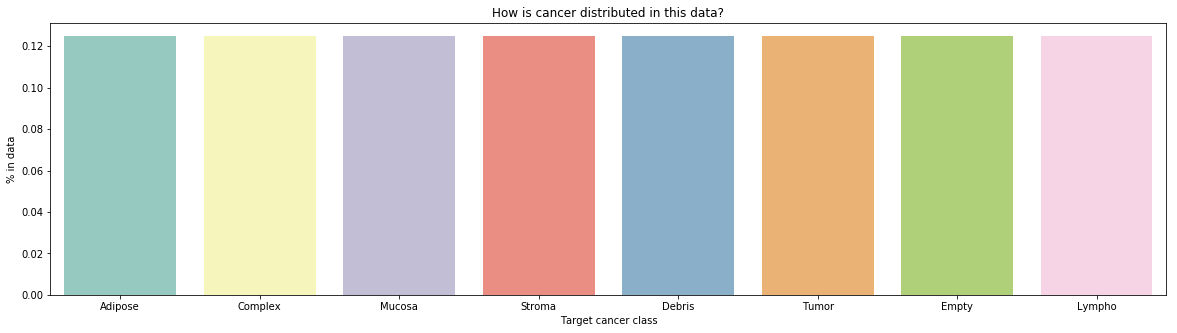

In [4]:
class_names = {1: "Tumor", 2: "Stroma", 3: "Complex", 4: "Lympho",
               5: "Debris", 6: "Mucosa", 7: "Adipose", 8: "Empty"}
class_numbers = {"Tumor": 1, "Stroma": 2, "Complex": 3, "Lympho": 4,
               "Debris": 5, "Mucosa": 6, "Adipose": 7, "Empty": 8}
class_colors = {1: "Red", 2: "Orange", 3: "Gold", 4: "Limegreen",
                5: "Mediumseagreen", 6: "Darkturquoise", 7: "Steelblue", 8: "Purple"}

label_percentage = df.label.value_counts() / df.shape[0]
class_index = [class_names[idx] for idx in label_percentage.index.values]

plt.figure(figsize=(20,5))
sns.barplot(x=class_index, y=label_percentage.values, palette="Set3");
plt.ylabel("% in data");
plt.xlabel("Target cancer class");
plt.title("How is cancer distributed in this data?");

In [5]:
tfms=get_transforms(flip_vert=True, max_warp=0.)

In [6]:
data = (ImageItemList.from_folder(path)
        .random_split_by_pct()
        .label_from_folder()
        .transform(tfms, size=150)
        .databunch(num_workers=2, bs=32))

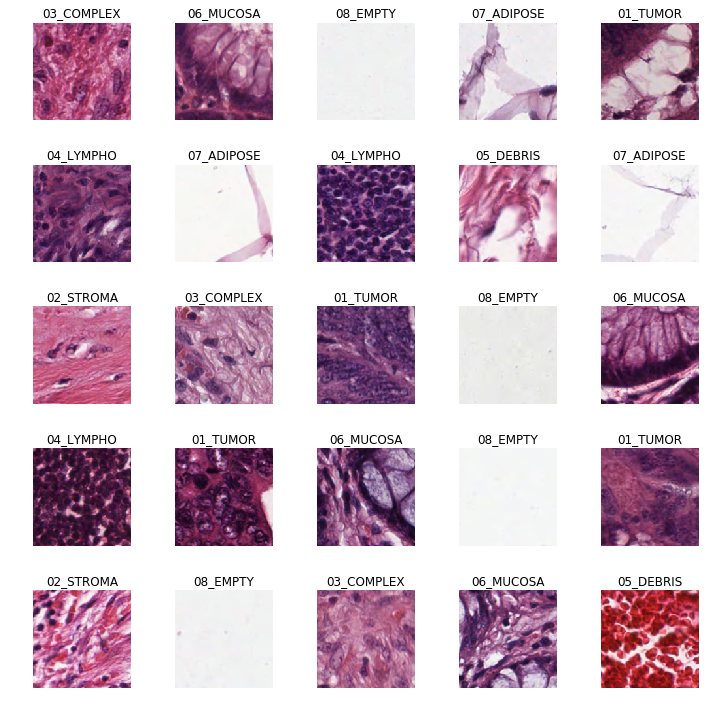

In [7]:
data.show_batch(row=3, figsize=(10,10))

## Model 

In [8]:
learner= create_cnn(data, models.resnet34, metrics=[accuracy], model_dir='/tmp/models/')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:09<00:00, 9608155.17it/s] 


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


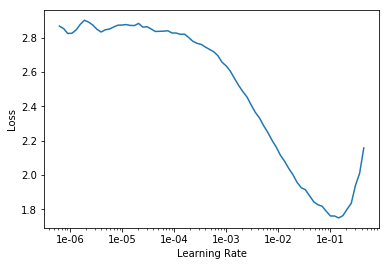

In [9]:
learner.lr_find()
learner.recorder.plot()

In [10]:
lr=5e-3
learner.fit_one_cycle(8, lr)

epoch,train_loss,valid_loss,accuracy
1,0.746260,0.331722,0.892000
2,0.447762,0.337679,0.885000
3,0.415871,0.252112,0.907000
4,0.349655,0.233475,0.925000
5,0.281179,0.192300,0.935000
6,0.257205,0.155625,0.945000
7,0.209400,0.141842,0.954000
8,0.185309,0.139866,0.953000


In [11]:
learner.save('stage-1')

In [12]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


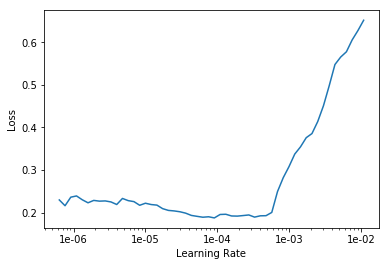

In [13]:
learner.lr_find()
learner.recorder.plot()

In [14]:
learner.fit_one_cycle(16, slice(5e-5,5e-4))

epoch,train_loss,valid_loss,accuracy
1,0.182312,0.150078,0.947000
2,0.192302,0.162475,0.938000
3,0.227757,0.214074,0.927000
4,0.259690,0.201592,0.934000
5,0.235343,0.188512,0.931000
6,0.222545,0.200192,0.920000
7,0.209757,0.160487,0.945000
8,0.179153,0.137458,0.949000
9,0.160975,0.153541,0.949000
10,0.142036,0.139526,0.950000


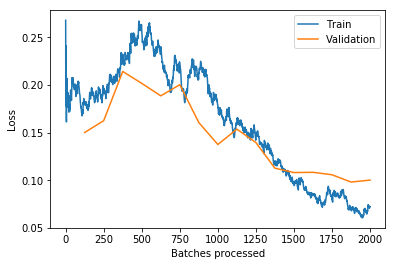

In [15]:
learner.recorder.plot_losses()

In [16]:
learner.save('stage-2')

## Evaluation

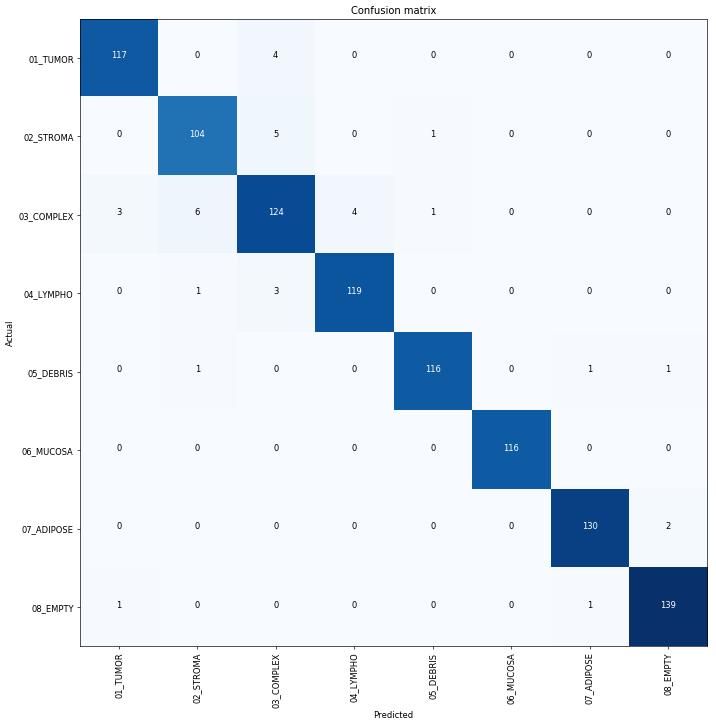

In [17]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [18]:
interp.most_confused()

[('03_COMPLEX', '02_STROMA', 6),
 ('02_STROMA', '03_COMPLEX', 5),
 ('01_TUMOR', '03_COMPLEX', 4),
 ('03_COMPLEX', '04_LYMPHO', 4),
 ('03_COMPLEX', '01_TUMOR', 3),
 ('04_LYMPHO', '03_COMPLEX', 3),
 ('07_ADIPOSE', '08_EMPTY', 2)]

In [19]:
preds, lb=learner.get_preds()

In [20]:
#  ROC curve
fpr, tpr, thresholds = roc_curve(lb.numpy(), preds.numpy()[:,1], pos_label=1)

#  ROC area
pred_score = auc(fpr, tpr)
print(f'ROC area is {pred_score}')

ROC area is 0.9974668028600613


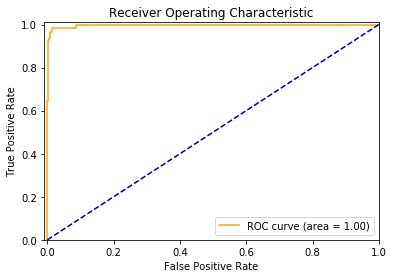

In [21]:
plt.figure()
plt.plot(fpr, tpr, color='orange', label='ROC curve (area = %0.2f)' % pred_score)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")